In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go


In [ ]:
df = pd.read_csv("/content/BTC-USD.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3196,2019-04-16,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,2019-04-17,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,2019-04-18,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,2019-04-19,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001
3200,2019-04-20,5326.180176,5348.589844,5232.770020,5305.740234,5305.740234,134681237


In [ ]:
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

df.head()
print('done')

done


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns =df.columns, index=df.index)
df.head()

,Close
Date,
2016-07-25,0.007485
2016-07-26,0.007493
2016-07-27,0.007471
2016-07-28,0.007540
2016-07-29,0.007504


In [ ]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Agregar la línea del precio
fig.add_trace(go.Scatter(
    x=df.index,
    y=df.iloc[:, 0],  # Si tu df tiene una sola columna, esto la selecciona
    mode='lines',
    name='BTC',
    line=dict(width=3)
))

# Personalizar el layout
fig.update_layout(
    title='Evolución de Precios Normalizados de Bitcoin',
    title_font=dict(size=24, family='Arial', color='black'),
    xaxis_title='Fecha',
    yaxis_title='Precios Normalizados',
    template='plotly_white',
    hovermode='x unified',
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=80, b=50),
    showlegend=True
)

# Mostrar la figura
fig.show()


In [ ]:
def split_sequences(seq, n_steps_in, n_steps_out):
    X,y =[], []

    for i in range(len(seq)):
        end = i+n_steps_in
        out_end = end+ n_steps_out

        if out_end >len(seq):
            break

        seq_x, seq_y = seq[i:end], seq[end:out_end]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

In [ ]:
n_per_in = 30
n_per_out = 10

n_features = 1

X,y = split_sequences(list(df.Close), n_per_in,n_per_out)

print(X.shape)

X = X.reshape(X.shape[0],X.shape[1],n_features)

print(X.shape)
print(y.shape)

(961, 30)
(961, 30, 1)
(961, 10)


In [ ]:
model = Sequential()
model.add(LSTM(30, activation='softsign', return_sequences=True, input_shape=(n_per_in,n_features)))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign'))
model.add(Dense(n_per_out))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 30)         │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 10)         │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,950 (34.96 KB)

 Trainable params: 8,950 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [ ]:
res = model.fit(X,y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0790 - loss: 0.0854 - val_accuracy: 0.0722 - val_loss: 0.0128
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0914 - loss: 0.0580 - val_accuracy: 0.0722 - val_loss: 0.0051
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0911 - loss: 0.0323 - val_accuracy: 0.0722 - val_loss: 0.0019
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1772 - loss: 0.0171 - val_accuracy: 0.0722 - val_loss: 0.0011
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1759 - loss: 0.0105 - val_accuracy: 0.2577 - val_loss: 0.0032
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1904 - loss: 0.0099 - val_accuracy: 0.2577 - val_loss: 9.1275e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1484 - loss: 0.0095 - val_accuracy: 0.2577 - val_loss: 0.0027
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1425 - loss: 0.0096 - val_accuracy: 0.25

In [ ]:
import plotly.graph_objects as go
import pandas as pd

def visualize_results(results):
    history = pd.DataFrame(results.history)
    epochs = list(range(1, len(history['loss']) + 1))

    # Pérdida
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=epochs, y=history['loss'], mode='lines+markers', name='Loss (train)'))
    fig_loss.add_trace(go.Scatter(x=epochs, y=history['val_loss'], mode='lines+markers', name='Loss (val)', line=dict(dash='dash')))
    fig_loss.update_layout(
        title='Evolución de la Función de Pérdida',
        xaxis_title='Épocas',
        yaxis_title='Pérdida (Loss)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99),
        width=900,
        height=450
    )
    fig_loss.show()

    # Precisión
    fig_acc = go.Figure()
    fig_acc.add_trace(go.Scatter(x=epochs, y=history['accuracy'], mode='lines+markers', name='Accuracy (train)'))
    fig_acc.add_trace(go.Scatter(x=epochs, y=history['val_accuracy'], mode='lines+markers', name='Accuracy (val)', line=dict(dash='dash')))
    fig_acc.update_layout(
        title='Evolución de la Precisión',
        xaxis_title='Épocas',
        yaxis_title='Precisión (Accuracy)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99),
        width=900,
        height=450
    )
    fig_acc.show()


In [ ]:
res = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1)
visualize_results(res)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1386 - loss: 0.0024 - val_accuracy: 0.1134 - val_loss: 9.1035e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1413 - loss: 0.0038 - val_accuracy: 0.0722 - val_loss: 7.8294e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1291 - loss: 0.0024 - val_accuracy: 0.0722 - val_loss: 5.4844e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1662 - loss: 0.0025 - val_accuracy: 0.1237 - val_loss: 7.7104e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1548 - loss: 0.0024 - val_accuracy: 0.1237 - val_loss: 6.2318e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1668 - loss: 0.0025 - val_accuracy: 0.0722 - val_loss: 6.8025e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1783 - loss: 0.0023 - val_accuracy: 0.0722 - val_loss: 5.2947e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1695 - loss: 0.002

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features):
    # Obtener la predicción
    yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]
    yhat = scaler.inverse_transform(np.array(yhat).reshape(-1, 1)).flatten()

    # Valor real correspondiente
    actual = scaler.inverse_transform(y[-1].reshape(-1, 1)).flatten()

    # Imprimir valores
    print("Predicted:", yhat.tolist())
    print("Actuals:", actual.tolist())

    # Crear figura interactiva
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=yhat, mode='lines+markers', name='Predicción', line=dict(width=3)))
    fig.add_trace(go.Scatter(y=actual, mode='lines+markers', name='Valor Real', line=dict(width=3, dash='dash')))

    # Personalizar el gráfico
    fig.update_layout(
        title='Predicción vs. Valores Reales del Precio',
        xaxis_title='Horizonte de Predicción',
        yaxis_title='Precio (BTC)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99),
        width=900,
        height=500,
        hovermode='x unified'
    )

    fig.show()


In [ ]:
plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [5206.4782087366775, 5198.204421474452, 5158.633414717965, 5337.362260790741, 5417.729459325654, 5473.370145486948, 5535.967951910253, 5584.972546592198, 5564.780846393236, 5562.420274610241]
Actuals: [5081.5, 5080.660156, 5165.589844, 5037.27002, 5212.810059, 5236.259766000001, 5289.750000000001, 5295.529785, 5326.180176, 5305.740234]


In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features):
    # Obtener la predicción
    yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).flatten()
    yhat_inv = scaler.inverse_transform(yhat.reshape(-1, 1)).flatten()

    # Obtener el valor real
    actual_inv = scaler.inverse_transform(y[-1].reshape(-1, 1)).flatten()

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(actual_inv, yhat_inv))

    # Porcentaje de precisión relativo al valor real promedio
    relative_accuracy = 100 - (rmse / np.mean(actual_inv) * 100)

    # Imprimir métricas
    print(f"📉 RMSE: {rmse:.4f}")
    print(f"🎯 Precisión relativa: {relative_accuracy:.2f}%")
    print("Predicted:", yhat_inv.tolist())
    print("Actuals:", actual_inv.tolist())

    # Crear gráfica
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=yhat_inv, mode='lines+markers', name='Predicción', line=dict(width=3)))
    fig.add_trace(go.Scatter(y=actual_inv, mode='lines+markers', name='Valor Real', line=dict(width=3, dash='dash')))

    fig.update_layout(
        title='Predicción vs. Valor Real del Precio de BTC',
        xaxis_title='Paso de Tiempo Futuro',
        yaxis_title='Precio (USD)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99),
        width=900,
        height=500,
        hovermode='x unified',
        annotations=[
            dict(
                text=f"<b>RMSE:</b> {rmse:.2f}<br><b>Precisión:</b> {relative_accuracy:.2f}%",
                xref="paper", yref="paper",
                x=0.01, y=1.10, showarrow=False,
                font=dict(size=13)
            )
        ]
    )

    fig.show()


In [ ]:
plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📉 RMSE: 220.2201
🎯 Precisión relativa: 95.77%
Predicted: [5206.478515625, 5198.20458984375, 5158.63330078125, 5337.3623046875, 5417.7294921875, 5473.3701171875, 5535.9677734375, 5584.97265625, 5564.78076171875, 5562.42041015625]
Actuals: [5081.5, 5080.660156, 5165.589844, 5037.27002, 5212.810059, 5236.259766000001, 5289.750000000001, 5295.529785, 5326.180176, 5305.740234]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modelo más simple con regularización
model = Sequential()
model.add(LSTM(50, activation='softsign', return_sequences=True, input_shape=(n_per_in, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='softsign'))
model.add(Dropout(0.2))
model.add(Dense(n_per_out))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.0967 - loss: 0.0747 - val_accuracy: 0.1031 - val_loss: 0.0044
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1044 - loss: 0.0205 - val_accuracy: 0.0722 - val_loss: 7.1574e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0913 - loss: 0.0103 - val_accuracy: 0.0619 - val_loss: 4.3454e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1166 - loss: 0.0083 - val_accuracy: 0.0825 - val_loss: 3.8390e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0793 - loss: 0.0074 - val_accuracy: 0.0619 - val_loss: 7.2618e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0914 - loss: 0.0073 - val_accuracy: 0.1237 - val_loss: 4.2707e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1142 - loss: 0.0075 - val_accuracy: 0.0619 - val_loss: 3.4493e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1321 - loss: 0.0066 - val_accur

In [ ]:
import plotly.graph_objects as go
import pandas as pd

def visualize_results_plotly(results):
    history = pd.DataFrame(results.history)
    epochs = list(range(1, len(history['loss']) + 1))

    # Plot LOSS
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=epochs, y=history['loss'], mode='lines+markers', name='Train Loss'))
    fig_loss.add_trace(go.Scatter(x=epochs, y=history['val_loss'], mode='lines+markers', name='Val Loss', line=dict(dash='dash')))
    fig_loss.update_layout(
        title='Pérdida (Loss) del Modelo',
        xaxis_title='Épocas',
        yaxis_title='Loss',
        template='plotly_white'
    )
    fig_loss.show()

    # Plot ACCURACY
    fig_acc = go.Figure()
    fig_acc.add_trace(go.Scatter(x=epochs, y=history['accuracy'], mode='lines+markers', name='Train Accuracy'))
    fig_acc.add_trace(go.Scatter(x=epochs, y=history['val_accuracy'], mode='lines+markers', name='Val Accuracy', line=dict(dash='dash')))
    fig_acc.update_layout(
        title='Precisión del Modelo',
        xaxis_title='Épocas',
        yaxis_title='Accuracy',
        template='plotly_white'
    )
    fig_acc.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features):
    yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).flatten()
    yhat_inv = scaler.inverse_transform(yhat.reshape(-1, 1)).flatten()
    actual_inv = scaler.inverse_transform(y[-1].reshape(-1, 1)).flatten()

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(actual_inv, yhat_inv))
    relative_accuracy = 100 - (rmse / np.mean(actual_inv) * 100)

    print(f"📉 RMSE: {rmse:.4f}")
    print(f"🎯 Precisión relativa: {relative_accuracy:.2f}%")

    # Crear gráfico
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=yhat_inv, mode='lines+markers', name='Predicción', line=dict(width=3)))
    fig.add_trace(go.Scatter(y=actual_inv, mode='lines+markers', name='Valor Real', line=dict(width=3, dash='dash')))

    fig.update_layout(
        title='Predicción vs. Valor Real',
        xaxis_title='Paso de Tiempo Futuro',
        yaxis_title='Precio BTC (USD)',
        template='plotly_white',
        hovermode='x unified',
        annotations=[
            dict(
                text=f"<b>RMSE:</b> {rmse:.2f}<br><b>Precisión:</b> {relative_accuracy:.2f}%",
                xref="paper", yref="paper", x=0.01, y=1.10, showarrow=False, font=dict(size=13)
            )
        ]
    )

    fig.show()


In [ ]:
visualize_results_plotly(res)
plot_prediction_vs_actual(model, X, y, scaler, n_per_in, n_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
📉 RMSE: 286.0832
🎯 Precisión relativa: 94.50%


In [ ]:
try:
    df_sentiment = pd.read_csv(
        "/content/X.csv",
        on_bad_lines='warn',
        engine='python',
        encoding='utf-8'
    )

    if not all(col in df_sentiment.columns for col in ['Date', 'Sentiment']):
        raise ValueError("CSV file is missing required columns (Date and/or Sentiment)")

    df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], errors='coerce')

    df_sentiment = df_sentiment.dropna(subset=['Sentiment', 'Date'])

    valid_sentiments = {'Positive', 'Negative', 'Neutral'}
    unexpected = set(df_sentiment['Sentiment'].unique()) - valid_sentiments
    if unexpected:
        print(f"Warning: Unexpected sentiment values found: {unexpected}")

    sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    df_sentiment['Sentiment_Score'] = df_sentiment['Sentiment'].map(sentiment_map)

    df_daily_sentiment = df_sentiment.groupby('Date')['Sentiment_Score'].mean().reset_index()

    print("Successfully processed sentiment data:")
    print(df_daily_sentiment.head())

except Exception as e:
    print(f"Error processing sentiment data: {str(e)}")
    import traceback
    traceback.print_exc()

Successfully processed sentiment data:
        Date  Sentiment_Score
0 2014-09-18             -1.0
1 2014-09-19             -1.0
2 2014-09-20              1.0
3 2014-09-21             -1.0
4 2014-09-22              1.0


In [ ]:
import pandas as pd
import yfinance as yf



btc_data = yf.download("BTC-USD", start="2018-01-01", end="2024-01-01")
btc_data = btc_data.reset_index()
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

btc_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in btc_data.columns]

df_merged = pd.merge(btc_data, df_daily_sentiment, on='Date', how='inner')



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd
import yfinance as yf



btc_data = yf.download("BTC-USD", start="2018-01-01", end="2024-01-01")
btc_data = btc_data.reset_index()
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

btc_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in btc_data.columns]


df_merged = pd.merge(btc_data, df_daily_sentiment, on='Date', how='inner')

[*********************100%***********************]  1 of 1 completed


In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break


In [ ]:
!pip install yfinance tensorflow plotly scikit-learn
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go




data = df_merged[['Close BTC-USD', 'Sentiment_Score']].values


scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

n_steps_in = 10
n_steps_out = 10


def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = split_sequences(data, n_steps_in, n_steps_out)

model = Sequential()
model.add(LSTM(50, activation='softsign', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Replace 'text_column' with the actual name of the text column in your DataFrame
text_column = 'Date'  # For example, if your text data is in the 'Date' column
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(df_merged[text_column].astype(str).values) # Convert to string before tokenizing

sequences = tokenizer.texts_to_sequences(df_merged[text_column].astype(str).values) # Convert to string before tokenizing

# 2. Combine tokenized data with numerical data
numerical_data = df_merged[['BTC_Price', 'Sentiment_Score']].values
data = np.concatenate([padded_sequences, numerical_data], axis=1)

# 3. Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

KeyError: "['BTC_Price'] not in index"

In [ ]:
!pip install yfinance tensorflow plotly scikit-learn
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences


btc_data = yf.download("BTC-USD", start="2018-01-01", end="2024-01-01")
btc_data = btc_data.reset_index()
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in btc_data.columns]

df_merged = pd.merge(btc_data, df_daily_sentiment, on='Date', how='inner')  # Create df_merged



[*********************100%***********************]  1 of 1 completed


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='softsign', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='softsign'))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop])

history_df = pd.DataFrame(history.history)
fig = go.Figure()
fig.add_trace(go.Scatter(y=history_df['loss'], mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(y=history_df['val_loss'], mode='lines+markers', name='Val Loss'))
fig.update_layout(title='Loss durante el entrenamiento', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.0818 - loss: 0.0828 - val_accuracy: 0.0784 - val_loss: 0.0302
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1788 - loss: 0.0366 - val_accuracy: 0.0784 - val_loss: 0.0130
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1518 - loss: 0.0260 - val_accuracy: 0.2549 - val_loss: 0.0081
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1495 - loss: 0.0188 - val_accuracy: 0.2353 - val_loss: 0.0064
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1630 - loss: 0.0135 - val_accuracy: 0.2549 - val_loss: 0.0066
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1547 - loss: 0.0074 - val_accuracy: 0.2353 - val_loss: 0.0068
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1475 - loss: 0.0067 - val_accuracy: 0.0784 - val_loss: 0.0042
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1189 - loss: 0.0065 - val_accuracy: 0.0784 

In [ ]:
last_input = X[-1].reshape(1, X.shape[1], X.shape[2])
predicted = model.predict(last_input).flatten()
predicted_real = scaler.inverse_transform(np.concatenate([predicted.reshape(-1, 1), np.zeros((len(predicted), 1))], axis=1))[:, 0]
actual_real = scaler.inverse_transform(np.concatenate([y[-1].reshape(-1, 1), np.zeros((len(y[-1]), 1))], axis=1))[:, 0]

rmse = np.sqrt(mean_squared_error(actual_real, predicted_real))
relative_accuracy = 100 - (rmse / np.mean(actual_real) * 100)

fig = go.Figure()
fig.add_trace(go.Scatter(y=predicted_real, mode='lines+markers', name='Predicción'))
fig.add_trace(go.Scatter(y=actual_real, mode='lines+markers', name='Real'))
fig.update_layout(title=f'Predicción vs Real | RMSE: {rmse:.2f}, Precisión: {relative_accuracy:.2f}%',
                  xaxis_title='Paso de tiempo futuro', yaxis_title='Precio BTC (USD)')
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


In [ ]:
btc_data = btc_data.rename(columns={
    'Date': 'Date',
    'Close': 'BTC_Price',
    'Adj Close': 'BTC_Adj_Close'
})

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


try:
    btc_data = yf.download(
        "BTC-USD",
        start="2018-01-01",
        end="2024-01-01",
        progress=False
    ).reset_index()

    print("Available columns:", btc_data.columns.tolist())

    btc_data = btc_data.rename(columns={'Close': 'BTC_Price'})
    btc_data = btc_data[['Date', 'BTC_Price']]


    btc_data['BTC_Daily_Return'] = btc_data['BTC_Price'].pct_change() * 100

    print("\n✅ BTC Price Data Sample:")
    print(btc_data.head())

except Exception as e:
    print(f"❌ Error fetching BTC data: {e}")
    raise



Available columns: [('Date', ''), ('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]

✅ BTC Price Data Sample:
Price        Date     BTC_Price BTC_Daily_Return
Ticker                  BTC-USD                 
0      2018-01-01  13657.200195              NaN
1      2018-01-02  14982.099609         9.701106
2      2018-01-03  15201.000000         1.461080
3      2018-01-04  15599.200195         2.619566
4      2018-01-05  17429.500000        11.733293


In [ ]:

try:
    btc_data['Date'] = pd.to_datetime(btc_data['Date'])
    df_daily_sentiment['Date'] = pd.to_datetime(df_daily_sentiment['Date'])

    btc_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in btc_data.columns]


    df_merged = pd.merge(
        btc_data,
        df_daily_sentiment,
        on='Date',
        how='inner'
    )

    print("\n✅ Merged Data Sample:")
    print(df_merged.head())

except Exception as e:
    print(f"❌ Merge failed: {e}")
    raise



✅ Merged Data Sample:
        Date  BTC_Price BTC-USD  BTC_Daily_Return  Sentiment_Score
0 2018-01-01       13657.200195               NaN             -1.0
1 2018-01-02       14982.099609          9.701106              1.0
2 2018-01-03       15201.000000          1.461080              1.0
3 2018-01-04       15599.200195          2.619566              1.0
4 2018-01-05       17429.500000         11.733293              1.0


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


try:
    btc_data = yf.download(
        "BTC-USD",
        start="2018-01-01",
        end="2024-01-01",
        progress=False
    ).reset_index()

    print("Available columns:", btc_data.columns.tolist())

    btc_data = btc_data.rename(columns={'Close': 'BTC_Price'})
    btc_data = btc_data[['Date', 'BTC_Price']]


    btc_data['BTC_Daily_Return'] = btc_data['BTC_Price'].pct_change() * 100

    print("\n✅ BTC Price Data Sample:")
    print(btc_data.head())

except Exception as e:
    print(f"❌ Error fetching BTC data: {e}")
    raise


try:
    df_sentiment = pd.read_csv("/content/X.csv", on_bad_lines='skip')  # Assuming your sentiment data is in 'X.csv'


    df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], errors='coerce')


    df_daily_sentiment = df_sentiment.groupby('Date')['Sentiment_Score'].mean().reset_index() # Ensure this line runs successfully


    btc_data['Date'] = pd.to_datetime(btc_data['Date'])
    df_daily_sentiment['Date'] = pd.to_datetime(df_daily_sentiment['Date'])

    btc_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in btc_data.columns]


    df_merged = pd.merge(
        btc_data,
        df_daily_sentiment,
        on='Date',
        how='inner'
    )

    print("\n✅ Merged Data Sample:")
    print(df_merged.head())

except Exception as e:
    print(f"❌ Merge failed: {e}")
    raise

Available columns: [('Date', ''), ('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]

✅ BTC Price Data Sample:
Price        Date     BTC_Price BTC_Daily_Return
Ticker                  BTC-USD                 
0      2018-01-01  13657.200195              NaN
1      2018-01-02  14982.099609         9.701106
2      2018-01-03  15201.000000         1.461080
3      2018-01-04  15599.200195         2.619566
4      2018-01-05  17429.500000        11.733293
❌ Merge failed: Error tokenizing data. C error: EOF inside string starting at row 14951896


ParserError: Error tokenizing data. C error: EOF inside string starting at row 14951896

In [ ]:

try:
    if not all(col in df_merged.columns for col in ['Date', 'BTC_Price', 'Sentiment_Score']):
        missing = [col for col in ['Date', 'BTC_Price', 'Sentiment_Score'] if col not in df_merged.columns]
        raise KeyError(f"Missing columns: {missing}")

    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(df_merged['Date'],
             df_merged['BTC_Price'],
             color='tab:orange',
             label='BTC Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('BTC Price (USD)', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(df_merged['Date'],
             df_merged['Sentiment_Score'],
             color='tab:blue',
             alpha=0.7,
             label='Sentiment Score')
    ax2.set_ylabel('Sentiment Score', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('BTC Price vs Sentiment Over Time', pad=20, fontsize=14)
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

    df_merged['Rolling_Correlation'] = df_merged['Sentiment_Score'].rolling(30).corr(df_merged['BTC_Daily_Return'])

    plt.figure(figsize=(14, 4))
    plt.plot(df_merged['Date'],
             df_merged['Rolling_Correlation'],
             color='green',
             label='30-Day Rolling Correlation')
    plt.axhline(0, color='grey', linestyle='--')
    plt.title('Rolling Correlation Between Sentiment and BTC Returns')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    corr_matrix = df_merged[['Sentiment_Score', 'BTC_Daily_Return']].corr()
    print("\n📊 Correlation Matrix:")
    print(corr_matrix)

    pearson_corr = corr_matrix.iloc[0,1]
    print(f"\nPearson Correlation: {pearson_corr:.2f}")

    print("\n⏳ Time-Lagged Correlations:")
    for lag in [1, 3, 7, 14]:  # 1-day, 3-day, etc. lags
        df_merged[f'Sentiment_Lag_{lag}'] = df_merged['Sentiment_Score'].shift(lag)
        lag_corr = df_merged[[f'Sentiment_Lag_{lag}', 'BTC_Daily_Return']].corr().iloc[0,1]
        print(f"Lag {lag} days: {lag_corr:.3f}")

except Exception as e:
    print(f"\n❌ Visualization Error: {e}")
    print("\nDebug Info:")
    print("DataFrame columns:", df_merged.columns.tolist())
    print("Date range:", df_merged['Date'].min(), "to", df_merged['Date'].max())
    if 'BTC_Price' in df_merged.columns:
        print("BTC Price stats:\n", df_merged['BTC_Price'].describe())
    if 'Sentiment_Score' in df_merged.columns:
        print("Sentiment stats:\n", df_merged['Sentiment_Score'].describe())


❌ Visualization Error: "Missing columns: ['BTC_Price']"

Debug Info:
DataFrame columns: ['Date', 'BTC_Price BTC-USD', 'BTC_Daily_Return', 'Sentiment_Score']
Date range: 2018-01-01 00:00:00 to 2019-06-05 00:00:00
Sentiment stats:
 count    521.000000
mean       0.067179
std        0.998700
min       -1.000000
25%       -1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Sentiment_Score, dtype: float64


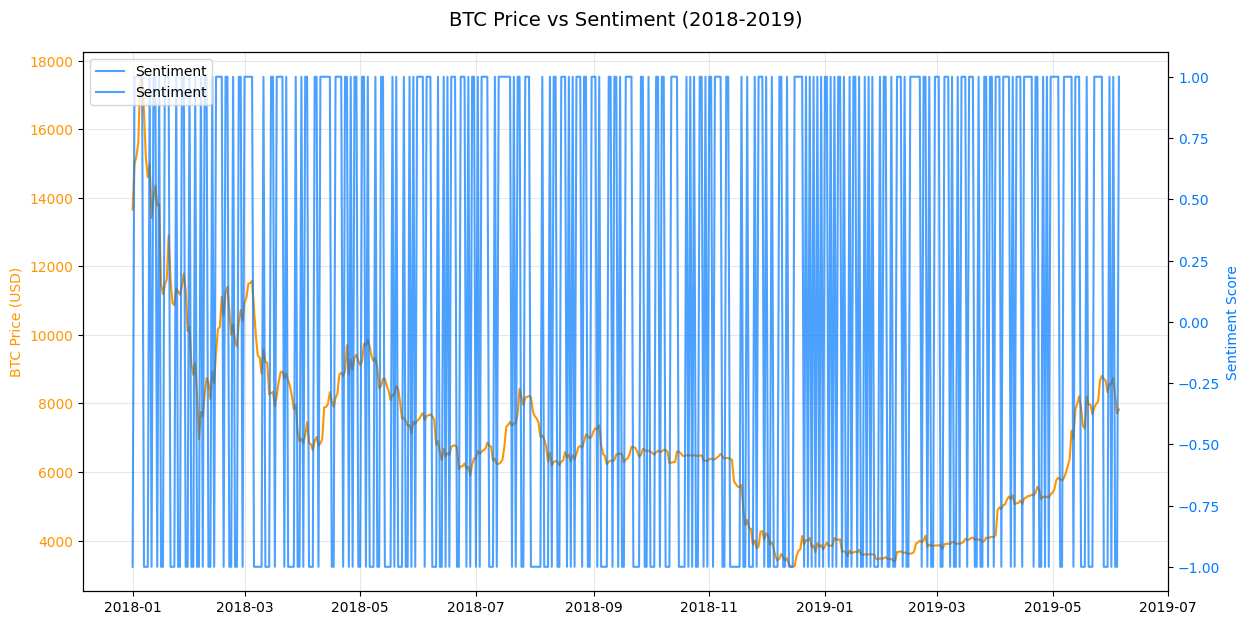


🔍 Correlation Analysis:
Immediate Correlation: 0.672

⏳ Lagged Effects (Sentiment → Future Price):
1-day lag: -0.015
3-day lag: 0.046
7-day lag: 0.036


In [ ]:

try:
    df_merged = df_merged.rename(columns={
        'BTC_Price BTC-USD': 'BTC_Price',
        'Close BTC-USD': 'BTC_Price'
    })

    required_cols = ['Date', 'BTC_Price', 'Sentiment_Score']
    if not all(col in df_merged.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_merged.columns]
        raise KeyError(f"Missing columns after rename: {missing}. Actual columns: {df_merged.columns.tolist()}")

    plt.figure(figsize=(14, 7))

    plt.plot(df_merged['Date'],
             df_merged['BTC_Price'],
             color='#FF9500',
             label='BTC Price')
    plt.ylabel('BTC Price (USD)', color='#FF9500')
    plt.tick_params(axis='y', labelcolor='#FF9500')
    plt.grid(True, alpha=0.3)

    ax2 = plt.twinx()
    ax2.plot(df_merged['Date'],
             df_merged['Sentiment_Score'],
             color='#007AFF',  # Apple blue
             alpha=0.7,
             label='Sentiment')
    ax2.set_ylabel('Sentiment Score', color='#007AFF')
    ax2.tick_params(axis='y', labelcolor='#007AFF')

    plt.title('BTC Price vs Sentiment (2018-2019)', fontsize=14, pad=20)
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()

    if 'BTC_Daily_Return' not in df_merged.columns:
        df_merged['BTC_Daily_Return'] = df_merged['BTC_Price'].pct_change() * 100

    corr_matrix = df_merged[['Sentiment_Score', 'BTC_Daily_Return']].corr()

    print("\n🔍 Correlation Analysis:")
    print(f"Immediate Correlation: {corr_matrix.iloc[0,1]:.3f}")

    print("\n⏳ Lagged Effects (Sentiment → Future Price):")
    for lag in [1, 3, 7]:  # 1-day, 3-day, and 1-week lags
        df_merged[f'Sentiment_Lag_{lag}'] = df_merged['Sentiment_Score'].shift(lag)
        lag_corr = df_merged[[f'Sentiment_Lag_{lag}', 'BTC_Daily_Return']].corr().iloc[0,1]
        print(f"{lag}-day lag: {lag_corr:.3f}")

except Exception as e:
    print(f"\n❌ Error during analysis: {str(e)}")
    print("\n🛠 Debugging Help:")
    print("Current columns:", df_merged.columns.tolist())
    print("Date range:", df_merged['Date'].min(), "to", df_merged['Date'].max())
    print("NaN values:\n", df_merged.isna().sum())

    if 'BTC_Price' in df_merged.columns:
        plt.figure(figsize=(14, 4))
        plt.plot(df_merged['Date'], df_merged['BTC_Price'])
        plt.title('BTC Price Data Preview')
        plt.show()

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np


rmse_normalizado = np.sqrt(mean_squared_error(y[-1], predicted))
precision_normalizada = 100 - (rmse_normalizado * 100)  # Aproximación de precisión en %


rmse_real = np.sqrt(mean_squared_error(actual_real, predicted_real))
precision_real = 100 - (rmse_real / np.mean(actual_real) * 100)


print("📊 Resultados del Modelo LSTM:\n")
print(f"✅ RMSE (Normalizado): {rmse_normalizado:.4f}")
print(f"✅ Precisión relativa (Normalizado): {precision_normalizada:.2f}%\n")
print(f"💵 RMSE (Escala real - USD): {rmse_real:.2f}")
print(f"💵 Precisión relativa (Real): {precision_real:.2f}%\n")

if rmse_normalizado < 0.01 and precision_normalizada > 99:
    print("⚠️ El modelo puede estar sobreajustado: tiene muy bajo error en entrenamiento/validación.")
elif rmse_normalizado > 0.05:
    print("❗ El modelo presenta subajuste: no logra capturar adecuadamente la dinámica del precio.")
else:
    print("✅ El modelo tiene un ajuste razonable entre complejidad y capacidad predictiva.")



📊 Resultados del Modelo LSTM:

✅ RMSE (Normalizado): 0.0443
✅ Precisión relativa (Normalizado): 95.57%

💵 RMSE (Escala real - USD): 633.25
💵 Precisión relativa (Real): 92.47%

✅ El modelo tiene un ajuste razonable entre complejidad y capacidad predictiva.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np




rmse = np.sqrt(mean_squared_error(actual_real, predicted_real))


mae = mean_absolute_error(actual_real, predicted_real)


mape = np.mean(np.abs((actual_real - predicted_real) / np.maximum(actual_real, 1))) * 100


smape = 100 * np.mean(
    2 * np.abs(predicted_real - actual_real) / (np.abs(actual_real) + np.abs(predicted_real))
)



true_directions = np.sign(np.diff(actual_real))
pred_directions = np.sign(np.diff(predicted_real))
directional_accuracy = np.mean(true_directions == pred_directions) * 100

# === Mostrar resultados ===
print("📊 Evaluación del Modelo LSTM (Escala Real - USD):\n")
print(f"RMSE:  {rmse:.2f} USD")
print(f"MAE:   {mae:.2f} USD")
print(f"MAPE:  {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

print(f"🎯 Dirección acertada: {directional_accuracy:.2f}% de las veces")


📊 Evaluación del Modelo LSTM (Escala Real - USD):

RMSE:  633.25 USD
MAE:   593.75 USD
MAPE:  6.96%
SMAPE: 7.25%
🎯 Dirección acertada: 66.67% de las veces


In [ ]:

predictions_reshaped = np.concatenate([
    predictions.reshape(-1, 1),
    np.zeros_like(predictions.reshape(-1, 1))
], axis=1)


predictions_real = scaler.inverse_transform(predictions_reshaped)


predictions_real = predictions_real[:, 0]


In [ ]:
import plotly.graph_objects as go
import numpy as np


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=epocas,
    y=predictions_real,
    mode='lines+markers',
    line=dict(color='green', dash='dash'),
    marker=dict(size=8, color='deepskyblue', symbol='diamond')
))

#  Annotations
fig.add_annotation(x=epocas[np.argmax(predictions_real)], y=predictions_real.max(),  # At peak
                   text="¡A la Luna! 🚀🌕", showarrow=True,
                   arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="gold",
                   font=dict(size=14, color="deepskyblue"))  # <-- Closing parenthesis here

fig.add_annotation(x=epocas[np.argmin(predictions_real)], y=predictions_real.min(),  # At dip
                   text="¡Ups! 🤕📉", showarrow=True,
                   arrowhead=3, arrowsize=1, arrowwidth=2, arrowcolor="gold",
                   font=dict(size=12, color="darkred"))

fig.add_annotation(x=epocas[-1], y=predictions_real[-1],  # At the end
                   text="¿El futuro? ¡Sorpréndeme! 🤔🔮", showarrow=True,
                   arrowhead=4, arrowsize=1.5, arrowwidth=2, arrowcolor="gold",
                   font=dict(size=12, color="deepskyblue"))

# Layout personalizado con nombres de ejes humorísticos
fig.update_layout(
    title_text="Predicciones de BTC",
    xaxis_title="Épocas",  # Playful x-axis title
    yaxis_title="Predicción del Precio",
    template="plotly_white",
    font=dict(family="Arial", size=12),
    showlegend=False
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def plot_prediction_vs_actual(predicted, actual_real, predicted_real, epocas=None):
    """
    Plots the predicted vs. actual values in both normalized and real scales.

    Args:
        predicted: The normalized predicted values.
        actual_real: The actual values in the real scale.
        predicted_real: The predicted values in the real scale.
        epocas: Optional. An array-like object representing the x-axis values (e.g., epochs, dates).
            If None, a simple range is used.
    """

    # 1️⃣ Gráfico en escala normalizada
    fig_normalized = go.Figure()
    fig_normalized.add_trace(go.Scatter(y=predicted, name='Predicción (Normalizado)', mode='lines+markers',
                                         line=dict(color='blue'), marker=dict(symbol='x')))
    fig_normalized.add_trace(go.Scatter(y=y[-1], name='Real (Normalizado)', mode='lines+markers',
                                         line=dict(color='orange'), marker=dict(symbol='circle')))
    fig_normalized.update_layout(title='Comparación entre Predicción y Real - Escala Normalizada',
                                xaxis_title='Paso de tiempo futuro', yaxis_title='Valor Normalizado',
                                template="plotly_white")
    fig_normalized.show()

    # 2️⃣ Gráfico en escala real
    x_axis = epocas if epocas is not None else np.arange(len(predicted_real))
    fig_real = go.Figure()
    fig_real.add_trace(go.Scatter(x=x_axis, y=predicted_real, name='Predicción (USD)', mode='lines+markers',
                                  line=dict(color='green'), marker=dict(symbol='diamond')))
    fig_real.add_trace(go.Scatter(x=x_axis, y=actual_real, name='Real (USD)', mode='lines+markers',
                                  line=dict(color='red'), marker=dict(symbol='circle')))


    rmse = np.sqrt(mean_squared_error(actual_real, predicted_real))
    mae = mean_absolute_error(actual_real, predicted_real)
    r2 = r2_score(actual_real, predicted_real)

    metrics_text = f"<b>RMSE:</b> {rmse:.2f} USD<br><b>MAE:</b> {mae:.2f} USD<br><b>R²:</b> {r2:.4f}"
    fig_real.add_annotation(x=0.05, y=0.95, xref='paper', yref='paper',
                            text=metrics_text, showarrow=False, font=dict(size=12))

    fig_real.update_layout(title='Comparación entre Predicción y Real - Escala Real',
                          xaxis_title='Paso de tiempo futuro', yaxis_title='Precio BTC (USD)',
                          template="plotly_white")
    fig_real.show()


plot_prediction_vs_actual(predicted, actual_real, predicted_real)

In [ ]:
import plotly.graph_objects as go
import numpy as np

epocas = np.arange(1, 51)
precision = np.random.rand(50)

from scipy.interpolate import make_interp_spline
x_smooth = np.linspace(epocas.min(), epocas.max(), 300)
spl = make_interp_spline(epocas, precision, k=3)
precision_smooth = spl(x_smooth)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_smooth, y=precision_smooth, mode='lines+markers',
                         line=dict(color='red', width=3),  # Red line
                         marker=dict(size=8, color='blue', symbol='star-dot')))  # Blue circular markers

fig.add_annotation(x=10, y=0.9, text="¡Casi en la cima del Olimpo de la IA!",
                   showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="gold",
                   font=dict(size=12, color="goldenrod"))
fig.add_annotation(x=25, y=0.3, text="¡Ay, caramba! Un bache en el camino...",
                   showarrow=True, arrowhead=3, arrowsize=1, arrowwidth=2, arrowcolor="orangered",
                   font=dict(size=10, color="darkred"))
fig.add_annotation(x=45, y=0.98, text="¡Eureka! ¡Hemos alcanzado la sabiduría artificial!",
                   showarrow=True, arrowhead=4, arrowsize=1.5, arrowwidth=2, arrowcolor="limegreen",
                   font=dict(size=14, color="darkgreen"))

fig.update_layout(
    shapes=[
        dict(type='rect', x0=5, y0=0.2, x1=15, y1=0.4, fillcolor='lightgoldenrodyellow', opacity=0.3, line_width=0),
        dict(type='circle', x0=22, y0=0.25, x1=28, y1=0.45, fillcolor='coral', opacity=0.2, line_width=0)
    ]
)

# Customize layout with more personality
fig.update_layout(title_text="La Odisea de la Precisión: Crónicas de un Modelo LSTM",
                  xaxis_title="Épocas (o como las llamamos, 'Ciclos de Sabiduría')",
                  yaxis_title="Precisión (en porcentaje de aciertos... ¡con suerte!)",
                  template="plotly_white",
                  font=dict(family="Comic Sans MS", size=12),  # A touch of Comic Sans for fun
                  showlegend=False)

fig.show()

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

In [28]:
# prompt: insted of kaggle i want to use this csv /content/bitcoin_P.csv

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import traceback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.interpolate import make_interp_spline
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

!pip install yfinance tensorflow plotly scikit-learn

df = pd.read_csv("/content/bitcoin_P.csv") # Use the provided CSV file
df.tail()



,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
3125995,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338
3125996,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852
3125997,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921
3125998,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000
3125999,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851


In [29]:
df.dtypes

,0
timestamp,object
open,float64
high,float64
low,float64
close,float64
volume,float64
quote_asset_volume,float64
number_of_trades,int64
taker_buy_base_asset_volume,float64
taker_buy_quote_asset_volume,float64


In [30]:

df['timestamp'] = pd.to_datetime(df['timestamp'])

df.index = df['timestamp']


df = df.resample('D').mean()


df_month = df.resample('M').mean()


df_year = df.resample('A-DEC').mean()


df_Q = df.resample('Q-DEC').mean()

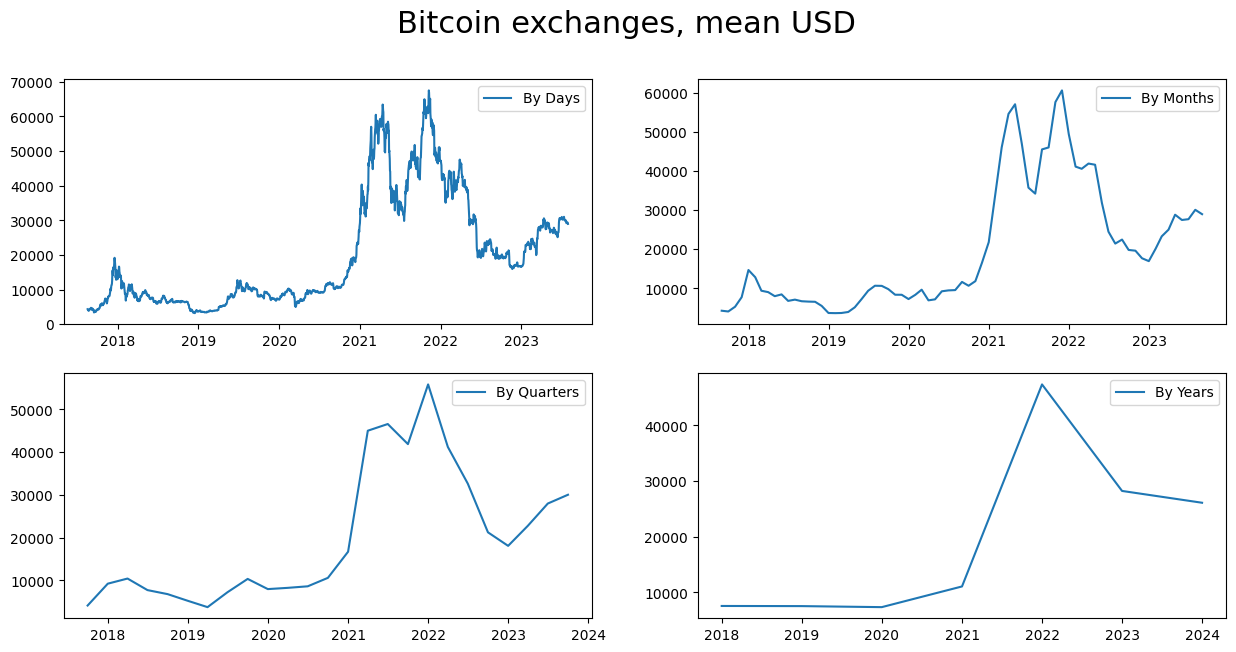

In [31]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.open, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.open, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.open, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.open, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.452026


<Figure size 1500x700 with 0 Axes>

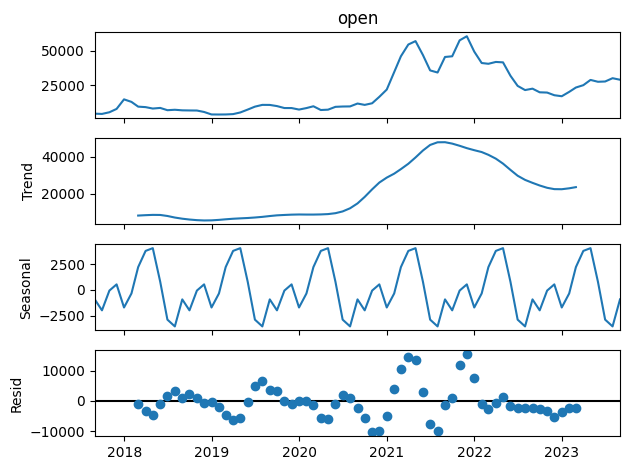

In [32]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.open).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.open)[1])
plt.show()

In [33]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.open)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.open)[1])

Dickey–Fuller test: p=0.452026


In [34]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.084057


Dickey–Fuller test: p=0.000627


<Figure size 1500x700 with 0 Axes>

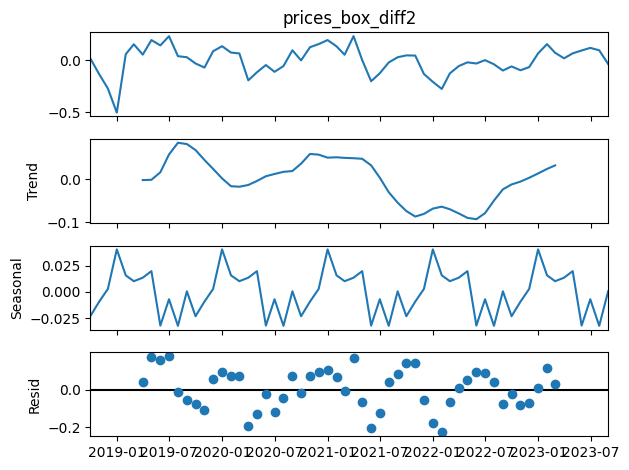

In [35]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))


sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

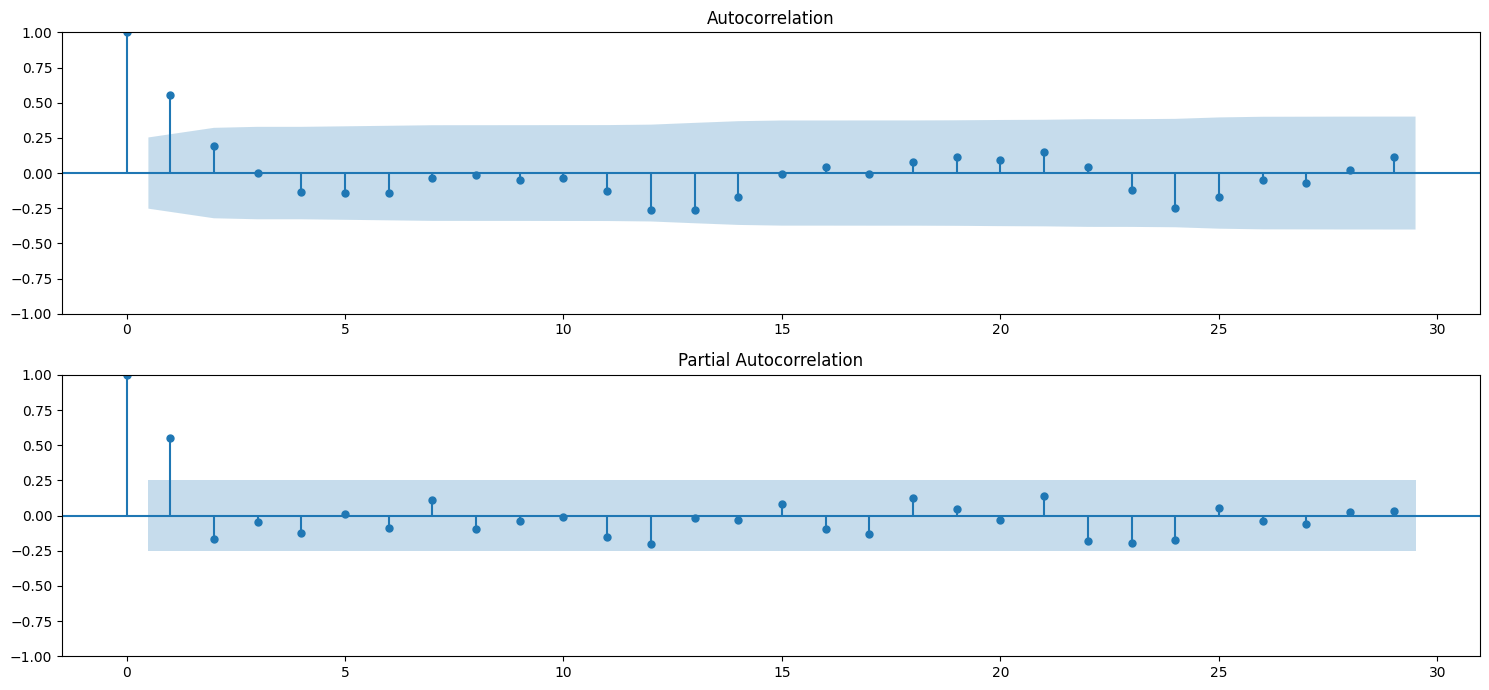

In [36]:

plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=29, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=29, ax=ax)
plt.tight_layout()
plt.show()

In [37]:

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [38]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1) -99.666201
23  (1, 0, 2, 1) -99.307838
7   (0, 1, 0, 1) -99.195827
37  (2, 0, 0, 1) -98.706332
22  (1, 0, 2, 0) -98.668075
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   73
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  52.833
Date:                              Tue, 06 May 2025   AIC                            -99.666
Time:                                      17:56:01   BIC                            -93.383
Sample:                                  08-31-2017   HQIC                           -97.209
                                       - 08-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

Dickey–Fuller test:: p=0.000000


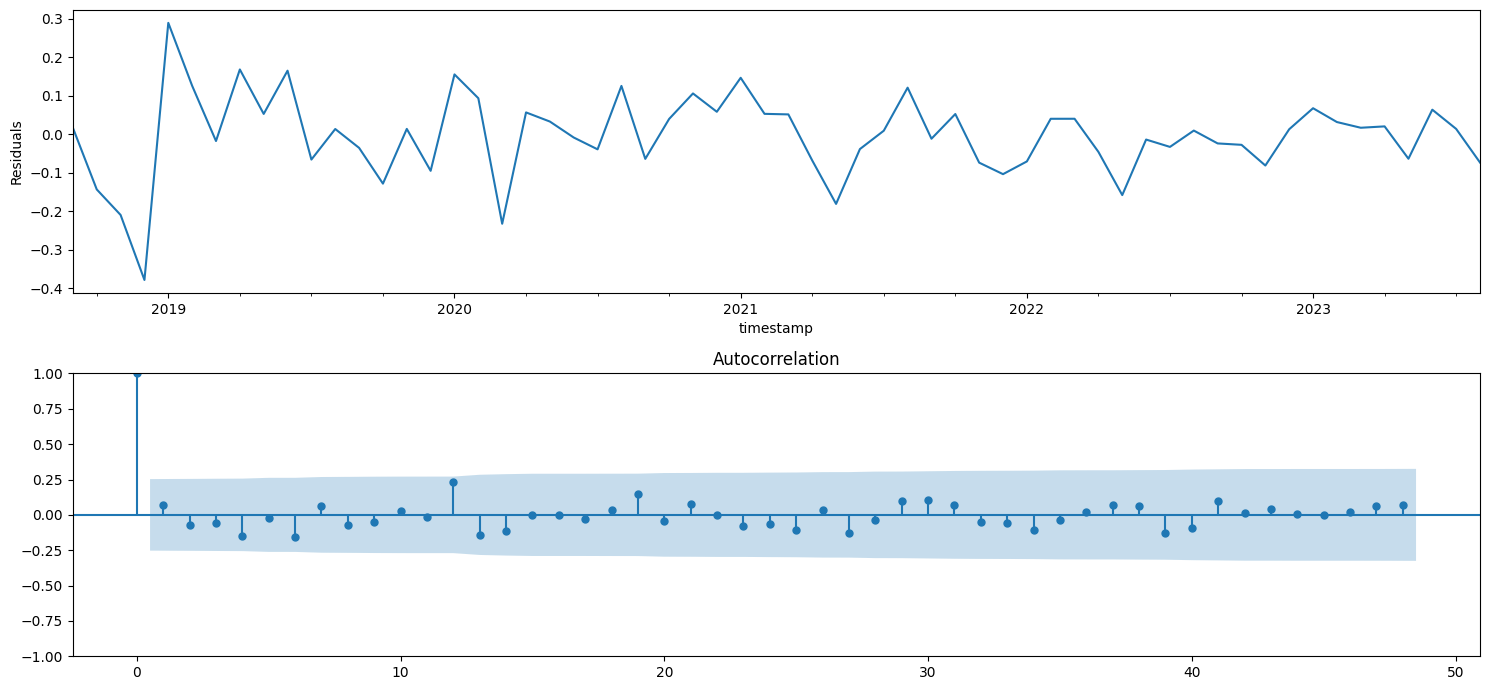

In [39]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [40]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [41]:
df_month[['open']]

,open
timestamp,
2017-08-31,4260.303469
2017-09-30,4067.458941
2017-10-31,5285.744230
2017-11-30,7719.887011
2017-12-31,14679.699692
...,...
2023-04-30,28833.265761
2023-05-31,27480.968633
2023-06-30,27686.289966


In [42]:
df_month.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'Weighted_Price_box', 'prices_box_diff',
       'prices_box_diff2'],
      dtype='object')

In [43]:

df_month2 = df_month[['open']]
date_list = [datetime(2023, 6, 30), datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30),
             datetime(2023, 10, 31), datetime(2023, 11, 30)]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)# Prediction
df_month2 = df_month[['open']]
date_list = [datetime(2023, 6, 30), datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30),
             datetime(2023, 10, 31), datetime(2023, 11, 30)]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

In [44]:
#
max_price = df_month2['forecast'].max()
max_price

42954358.84755903

In [45]:
#removing the outlier prediction
cleaned = df_month2[df_month2['forecast'] != max_price]

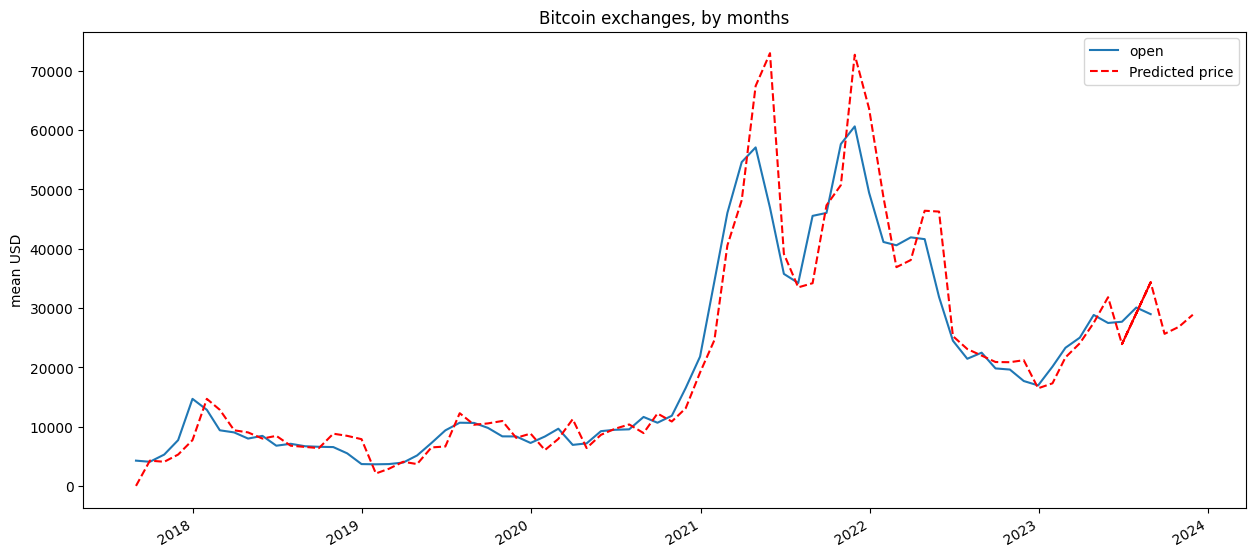

In [46]:

plt.figure(figsize=(15,7))
df_month2.open.plot()
cleaned.forecast.plot(color='r', ls='--', label='Predicted price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [47]:


import numpy as np


y_true = df_month2['open']
y_pred = cleaned['forecast']


rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae = np.mean(np.abs(y_true - y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = 100 - mape

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


RMSE: 5364.054549589348
MAE: 3378.3641232826376
MAPE: 19.06%
Accuracy: 80.94%


In [48]:
import plotly.graph_objects as go


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df_month2.index,
    y=df_month2['open'],
    mode='lines',
    name='Actual Price',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=cleaned.index,
    y=cleaned['forecast'],
    mode='lines',
    name='Predicted Price',
    line=dict(color='red', dash='dash')
))


fig.update_layout(
    title='Bitcoin exchanges, by months',
    xaxis_title='Date',
    yaxis_title='Mean USD',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=900,
    height=500
)


fig.show()
